### Introduction
So far, we have worked with images and numeric data, and you may be wondering how to apply machine learning models to text data. We will use the IMDB movie review dataset to develop a classification model to automatically label movie reviews as “positive” or “negative”.

In this unit, we will focus on how to preprocess text to make it suitable for classification models. Text data can be “messy”, especially from social media platforms. Moreover, not all terms in a text help to make good predictions. For these reasons, we usually start by preprocessing our text, i.e., “cleaning” it to keep only “informative” terms and remove other, less useful terms. Text preprocessing also aims to reduce the overall number of unique words in a dataset, using techniques such as case conversion and stemming, as we will discuss later. Overall, text preprocessing can improve training by reducing the memory required to handle the data, speeding up computations, and improving model performance.

We can’t use text data directly with machine learning algorithms. After “cleaning”, we need to convert text data into numerical representations compatible with machine learning models. This is the feature extraction process from text data and will be the topic of the next unit.

Here is the outline of the steps we will go through in this unit:

* Loading the data
* Preliminary EDA
* Text preprocessing

In the next unit, we will extract features from text data and train a classifier.

#### Loading the data
Let’s start by loading the data from the c4_imdb-8k.zip file provided in the Resources tab. Note that this is smaller version of the IMDB movie review dataset.

We will start by extracting the dataset into the c4_imdb-8k folder.



In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [3]:
# Unzip c4_imdb-8k.zip file

from zipfile import ZipFile

with ZipFile("c4_imdb-8k.zip", "r") as zip:
    print("Extracting all the files now...")
    zip.extractall()
    print("Done!")


Extracting all the files now...
Done!


The c4_imdb-8k folder has a train/ and a test/ directory, each containing text files with positive and negative reviews. We will use the datasets.load_files() method from scikit-learn to load the reviews. load_files() will also extract the label for each sample from the subfolders’ names (pos/ or neg/).

In [4]:
from sklearn.datasets import load_files

# Path to datafolder
PATH_DATA = "c4_imdb-8k"

# Load training data
train_data = load_files(
    os.path.join(PATH_DATA, "train"), encoding="ISO-8859-1", categories=["pos", "neg"]
)

# Load test data
test_data = load_files(
    os.path.join(PATH_DATA, "test"), encoding="ISO-8859-1", categories=["pos", "neg"]
)

train_data and test_data are dictionary-like objects with a few interesting attributes:

* the attribute data returns a list of all text samples
* the attribute target returns the labels (as integers)
* the attribute target_names returns the names of the target classes.

For more information on the datasets.load_files() method, please check scikit-learn’s online documentation page.

Let’s have a quick look at the number of samples in the training and test sets.

In [5]:
#  Training data
print(
    "Training data : Samples: {} - Labels: {} ".format(
        len(train_data.data), len(train_data.target)
    )
)

# Test data
print(
    "Test data     : Samples: {} - Labels: {} ".format(
        len(test_data.data), len(test_data.target)
    )
)

Training data : Samples: 8000 - Labels: 8000 
Test data     : Samples: 8000 - Labels: 8000 


Let’s check the target names and print a few labels from the training data.

In [6]:
# Check target names
train_data.target_names

['neg', 'pos']

For negative reviews, the target value is 0; for positive reviews, it is 1.

In [7]:
# Print labels of first 3 samples
train_data.target[0:3]  # [neg, neg, pos]

array([0, 0, 1])

In [8]:
# Print a review
train_data.data[1]

'Whatever possessed Guy Ritchie to remake Wertmuller\'s film is incomprehensible.<br /><br />This new film is a mess. There was one other person in the audience when I saw it, and she left about an hour into it. (I hope she demanded a refund.) The only reason I stayed through to the end was because I\'ve never walked out of a movie.<br /><br />But I sat through this piece of junk thoroughly flabbergasted that Madonna and Ritchie could actually think they made a good film. The dialogue is laughable, the acting is atrocious and the only nice thing in this film is the scenery. Ritchie took Lina\'s movie and turned it into another "Blue Lagoon."<br /><br />This is a film that you wouldn\'t even waste time watching late night on Cinemax. Time is too precious to be wasted on crap like this.'

We will now load the training and test data in dataframes.

In [10]:
#Load data in a dataframe
import pandas as pd

# Training data
df = pd.DataFrame({"text": train_data.data, "label": train_data.target})

# Test data
df_test = pd.DataFrame({"text": test_data.data, "label": test_data.target})

print("Training data: ", df.shape)
print("Test  data:    ", df_test.shape)

Training data:  (8000, 2)
Test  data:     (8000, 2)


Let’s check the data for duplicated entries.

In [11]:
print("Nbr of duplicates in training data: {}".format(df.duplicated().sum()))
print("Nbr of duplicates in test data:  {}".format(df_test.duplicated().sum()))

Nbr of duplicates in training data: 14
Nbr of duplicates in test data:  38


Next, we will remove the duplicated reviews.

In [12]:
# Drop duplicates from training/test data
df.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print("Training data: ", df.shape)
print("Test  data:    ", df_test.shape)

Training data:  (7986, 2)
Test  data:     (7962, 2)


Let’s print a few rows from the data.

In [13]:
# Print a few samples from the training data
df.sample(5)

,text,label
3908,"2003 was seen as the year of the Matrix, with ...",1
3117,Alex D. Linz replaces Macaulay Culkin as the c...,0
4603,I saw this movie at a 'sneak preview' and i mu...,0
3821,"While being a great James Arness western, this...",0
4925,"""American Nightmare"" is officially tied, in my...",0


In [14]:
# Print a few samples from the test data
df_test.sample(3)

,text,label
7198,"When I say worse, I mean less entertaining. To...",0
3239,"The inspiration for the ""Naked Gun"" movies cas...",1
5053,Do NOT avoid this movie. Simply because it is ...,0


#### Preliminary EDA
Note that our objective is not to do a thorough analysis of text data but just to showcase how some of the machine learning models that you learned in this course can be applied to them. Therefore, we will skip most of the Explanatory Data Analysis (EDA), which nevertheless is one of the main pillars of every machine learning project, in order to focus on our main goal.

Let’s see how many positive and how many negative reviews we have in the training and test datasets.

In [15]:
# Number of samples per class in training data
df["label"].value_counts()

1    3995
0    3991
Name: label, dtype: int64

In [16]:
# Number of samples per class in test data
df_test["label"].value_counts()

0    3987
1    3975
Name: label, dtype: int64

We have approximately the same number of positive and negative reviews in the training and the test data. Therefore, we can assume that our dataset is balanced.

The following plot shows the distribution of words in the reviews.



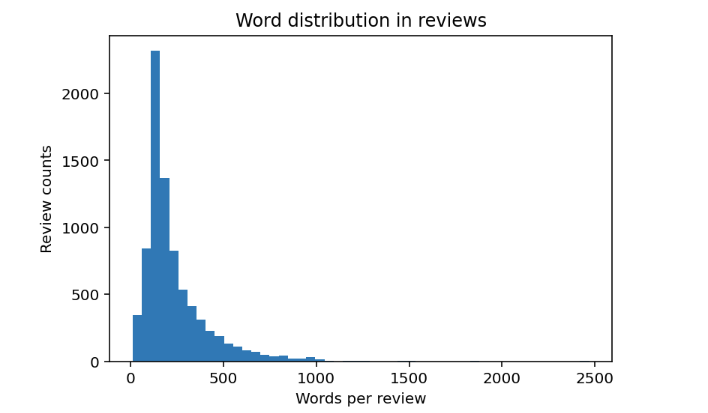

In [55]:
from IPython.display import Image
Image(filename="word.png")

Text preprocessing
As we said earlier, we usually start by cleaning our texts, which can help optimize learning. At this stage, it is important to “inspect” our text data to familiarize ourselves with the issues that we need to address during preprocessing.

In [17]:
# Print a few samples
df.sample(3)


,text,label
6907,Let me say first that this show was top tier w...,1
2295,It's not quite the timeless masterpiece you wo...,1
5583,"You know, this movie isn't that great, but, I ...",1


Below is a list of “issues” that we think we should address in this particular dataset.

* Remove numbers and HTML code for line breaks (<br />).
* Convert text to lowercase.
* Remove stop words.
* Remove punctuation.
* Apply stemming.

We will discuss all of these points in detail. Please note, however, that these points may vary depending on your particular dataset and that you may have to adapt the techniques discussed below to your specific task.

#### Remove numbers and HTML code for line breaks.
As we said above, with text preprocessing, we aim at removing terms that are not “informative” for making good predictions. Below are a few pointers:

HTML code (e.g. <br />) isn’t helpful for “guessing” the sentiment of a review and can be removed from the text.
Numbers (such as dates, years, prices, etc.) aren’t usually indicative of the sentiment of a review; hence we have decided to remove them from the text. However, depending on your task, you may want to verify the validity of this claim with appropriate Explanatory Data Analysis (EDA).
We will use regular expressions to remove numbers and HTML code for line breaks. Let’s see this with an example.

In [18]:
sample = "I don't like the director's suit. But I LOVED his movie! 10/10 <br /><br />"

print("Text sample: \n{}\n".format(sample))

Text sample: 
I don't like the director's suit. But I LOVED his movie! 10/10 <br /><br />



In [19]:
import re

# Remove html code for line breaks
clean_sample = re.sub(r"<br />", " ", sample)

print("Remove html code for line breaks: \n{}\n".format(clean_sample))


Remove html code for line breaks: 
I don't like the director's suit. But I LOVED his movie! 10/10   



In [20]:
# Remove numbers
clean_sample = re.sub(r"\d+", "", clean_sample)

print("Remove numbers from sample: \n{}\n".format(clean_sample))

Remove numbers from sample: 
I don't like the director's suit. But I LOVED his movie! /   



#### Case folding
Text preprocessing also aims at reducing the overall number of unique words in our dataset by cleaning redundancies. The number of unique words in a dataset is usually called the vocabulary; this is a term that you will often hear if you work with text data. Reducing the vocabulary size has the benefit of reducing the computational resources required to train a machine learning model.

It is common to convert text samples to lowercase; instead of including all capitalized and lowercase versions of a word in the vocabulary (e.g. “loved”, “LOVED”, and “Loved”), we keep only terms in lowercase (“loved”). Usually, this helps to reduce the vocabulary size without affecting model performance.

In [22]:
# Case folding
clean_sample = clean_sample.lower()

print("Convert to lowercase: \n{}\n".format(clean_sample))

Convert to lowercase: 
i don't like the director's suit. but i loved his movie! /   



#### Tokenization
Before we move on to removing stop words, punctuation and applying stemming, we should discuss tokenization.

Tokenization is the process of splitting text into smaller segments (usually words) called tokens and is utilized both during preprocessing and feature extraction.

The simplest way to tokenize a sentence is to split it on whitespace.



In [23]:
print(clean_sample.split())


['i', "don't", 'like', 'the', "director's", 'suit.', 'but', 'i', 'loved', 'his', 'movie!', '/']


However, this tokenizer is a bit “naive”. For example:

* It didn’t separate punctuation from the adjacent words (e.g. “suit.”, “movie!”).
* It didn’t separate the token “‘s” from the word “director”.
* It didn’t expand the contraction “don’t” to its constituent words “do” and “n’t”.

Most Natural language processing (NLP) libraries provide more “sophisticated” tokenizers. We will use the TreebankWordTokenizer from the Natural Language Toolkit (NLTK) library.

#### The TreebankWordTokenizer

The TreebankWordTokenizer incorporates common rules for English grammar and offers a few nice options. For example:

* It separates most punctuation characters from adjacent words.
* It splits standard contractions, e.g. don’t -> do   n’t and they’ll -> they   ‘ll

Let’s use the TreebankWordTokenizer with the text sample from above.

In [24]:
# Import tokenizer
from nltk.tokenize import TreebankWordTokenizer

# Create an instance of the TreebankWordTokenizer object
tokenizer = TreebankWordTokenizer()

print("Before tokenization: \n{}\n".format(clean_sample))
print("After tokenization: \n{}\n".format(tokenizer.tokenize(clean_sample)))


Before tokenization: 
i don't like the director's suit. but i loved his movie! /   

After tokenization: 
['i', 'do', "n't", 'like', 'the', 'director', "'s", 'suit.', 'but', 'i', 'loved', 'his', 'movie', '!', '/']



The TreebankWordTokenizer did a better job than our “naive” tokenizer. For example, the exclamation mark ! was separated from the word “movie”. However, it didn’t separate the period from the word “suit”. This is because the TreebankWordTokenizer assumes that the text has already been segmented into sentences (our text sample has two sentences).

For this reason, we need to first split the text into sentences using the nltk.tokenize.sent_tokenize() method and then tokenize each sentence with the TreebankWordTokenizer.

The review_tokenizer() function below, implements both steps:

* splits the text into sentences
* tokenizes each sentence.


In [25]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt", quiet=True)


def review_tokenizer(text):
    """
    Input: a sentence, or sentences
    Ouput: list of tokens

    """
    # Create empty list
    words = []

    # Split into sentences
    sentences = sent_tokenize(text)

    for sent in sentences:
        words.extend(tokenizer.tokenize(sent))
    return words


print("Before tokenization: \n{}\n".format(clean_sample))
print("After tokenization: \n{}\n".format(review_tokenizer(clean_sample)))

Before tokenization: 
i don't like the director's suit. but i loved his movie! /   

After tokenization: 
['i', 'do', "n't", 'like', 'the', 'director', "'s", 'suit', '.', 'but', 'i', 'loved', 'his', 'movie', '!', '/']



This looks much better. We can now move on to removing stop words and punctuation characters!

#### Stop words
Stop words are words that are essential for a sentence to make sense, such as: “I”, “the”, “and”, etc. The issue with stop words is that they are: very frequent and uninformative. For most NLP applications, it is a good idea to remove them from the text.

Most NLP libraries provide pre-compiled lists of stopwords for several languages. We will use the list provided by the NLTK library for English.



In [26]:
# Load english stopwords from nltk

nltk.download("stopwords", quiet=True)

from nltk.corpus import stopwords

stopwords_english = stopwords.words("english")

NLTK provides lists of stopwords for several other languages, such as French, German, Dutch, Spanish, Italian, Russian, Portuguese, etc. For more information, please check NLTK’s website.

In [27]:
# Print stopwords

print("{} stopwords in NLTK's list.\n".format(len(stopwords_english)))
print(stopwords_english)

179 stopwords in NLTK's list.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',

We can remove stop words using our review_tokenizer function and list comprehensions.

In [28]:
print("Before removing stop words: \n{}\n".format(clean_sample))

# Use a list comprehension to remove stopwords from clean_sample
print([tok for tok in review_tokenizer(clean_sample) if tok not in stopwords_english])

Before removing stop words: 
i don't like the director's suit. but i loved his movie! /   

["n't", 'like', 'director', "'s", 'suit', '.', 'loved', 'movie', '!', '/']


We can join lists of tokens into a string using the join() function.

In [29]:
print("Before removing stop words: \n{}\n".format(clean_sample))

clean_sample = " ".join(
    [tok for tok in review_tokenizer(clean_sample) if tok not in stopwords_english]
)
print("After removing stop words: \n{}\n".format(clean_sample))


Before removing stop words: 
i don't like the director's suit. but i loved his movie! /   

After removing stop words: 
n't like director 's suit . loved movie ! /



##### Modifying stop words lists

We can also modify stop words lists (by removing or adding terms) to adapt them to a specific task. For example, you may have noticed that NLTK’s stop word list for English contains a few negation words. Let’s check this with code.

In [30]:
# Check if 'not' is in stopwords_english

"not" in stopwords_english

True

In [31]:
# Check if "no" is in stopwords_english

"no" in stopwords_english

True

In [32]:
# Check if "nor" is in stopwords_english

"nor" in stopwords_english

True

In [33]:
# Check if "n't" is in stopwords_english

"n't" in stopwords_english

False

Negation words such as: “not”, “no”, and “nor” are part of NLTK’s stop word list. However, removing negation words from the text may be undesirable for some tasks, such as sentiment analysis. In the next cell, we show how to remove words from stop words lists.

In [34]:
# Modify nltk's stop word list: Remove negation words

not_stopwords = {"no", "nor", "not"}

custom_stopwords = set(
    [word for word in stopwords_english if word not in not_stopwords]
)

We can also add words to stop words lists like this.



In [35]:
# Modify nltk's stop word list: Add tokens "'s'" and "'m"

custom_stopwords = custom_stopwords.union({"'s", "'m"})

In [36]:
print("{} stopwords in customized NLTK's list.\n".format(len(custom_stopwords)))

print(custom_stopwords)

178 stopwords in customized NLTK's list.

{'then', "she's", 'where', 'herself', 'both', 'above', "couldn't", "that'll", 'yourselves', 'haven', 'she', 'which', 'but', 'into', 'ain', 'my', "don't", 'are', 'below', 'on', 'they', 'this', 'these', "weren't", 'shan', 'how', 'itself', 'further', 'some', 'wouldn', 'it', 'with', 'up', 'that', 'won', 'most', 'do', 'he', 'very', 'our', 'himself', "won't", 'her', 'too', 'few', 'me', 'were', 'there', 'other', 'their', "haven't", 'had', 'about', 'doesn', 'yourself', 'ourselves', 're', 'did', 'your', 'those', 'does', 'only', 'down', 'once', 'again', 'was', 'themselves', 'having', 'y', 'aren', 'hers', 'and', 'at', 'isn', "you'd", 'as', 'i', 'doing', 'have', 'or', 'between', 'out', 'during', 'of', 'in', "mustn't", 'each', "wasn't", 'has', 'you', 'for', 'against', 'before', "you've", 'through', 'over', "it's", 'will', "hadn't", 'ours', 'all', 'hadn', 'by', 'because', 'under', 'its', 'if', "should've", "'m", 'o', "you'll", 'being', 'mightn', "needn't", '

In [37]:
# Check if 'no' is in custom_stopwords

"no" in custom_stopwords

False

In [38]:
# Check if "'s" is in custom_stopwords

"'s" in custom_stopwords

True

In [39]:
# Check if "'m" is in custom_stopwords

"'m" in custom_stopwords

True

Let’s remove stop words using our custom_stopwords.

In [40]:
clean_sample = " ".join(
    [tok for tok in review_tokenizer(clean_sample) if tok not in custom_stopwords]
)
print(
    "After removing stop words using our custom stopwords list: \n{}\n".format(
        clean_sample
    )
)


After removing stop words using our custom stopwords list: 
n't like director suit . loved movie ! /



#### Punctuation
We will now remove punctuation characters using the string library.



In [41]:
import string

# string.punctuation returns all punctuation characters in a string
print(type(string.punctuation))
print(string.punctuation)


<class 'str'>
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


We can remove punctuation characters using the review_tokenizer function and list comprehensions.

In [42]:
# Use a list comprehension to remove punctuation characters from clean_sample
" ".join(
    [tok for tok in review_tokenizer(clean_sample) if tok not in string.punctuation]
)

"n't like director suit loved movie"

#### Stemming
Stemming is a commonly used technique for reducing vocabulary size. It is the process of converting a word to its “root” or “stem”, mainly by stripping suffixes from the end of a word. Note that stemming can produce non-words, i.e., words that you won’t find in a dictionary, so please keep this in mind if you need your preprocessed text to be “readable”.

Below are a few examples of how stemming works.

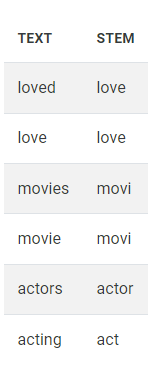

In [54]:
from IPython.display import Image
Image(filename="stemming.png")

The Porter stemmer is widely used for English text and is available in the NLTK library.

In [43]:
# Load stemmer
from nltk.stem.porter import PorterStemmer

# Create an instance of the PorterStemmer object
stemmer = PorterStemmer()

To stem a word, we call the stem function of the stemmer. Let’s see this with a few examples below.



In [44]:
# Stem of "loved"
stemmer.stem("loved")

'love'

In [45]:
# Stem of "love"
stemmer.stem("love")

'love'

Below we include stemming in our preprocessing pipeline.



In [46]:
print("Raw sample: \n{}\n".format(sample))

# Remove html code for line breaks
clean_sample = re.sub(r"<br />", " ", sample)

# Remove numbers
clean_sample = re.sub(r"\d+", "", clean_sample)

print("Remove line breaks and numbers: \n{}\n".format(clean_sample))

# Case folding
clean_sample = clean_sample.lower()
print("Convert to lowercase: \n{}\n".format(clean_sample))

# Remove stopwords & punctuation and stem tokens
clean_sample = " ".join(
    [
        stemmer.stem(word)
        for word in review_tokenizer(clean_sample)
        if (word not in string.punctuation) and (word not in custom_stopwords)
    ]
)

print("Remove stopwords & punctuation and stem tokens: \n{}\n".format(clean_sample))


Raw sample: 
I don't like the director's suit. But I LOVED his movie! 10/10 <br /><br />

Remove line breaks and numbers: 
I don't like the director's suit. But I LOVED his movie! /   

Convert to lowercase: 
i don't like the director's suit. but i loved his movie! /   

Remove stopwords & punctuation and stem tokens: 
n't like director suit love movi



As we see, after processing, we reduced our text sample to: “n’t like director suit love movi”. We were able to keep “informative” terms in the processed text, such as: “n’t”, “like” and “love”, which can help to guess the “sentiment” of this movie review.

##### Stemming vs. Lemmatization

In the previous cells, we used stemming to connect similar words and reduce vocabulary size. However, stemming can generate “non-words”, i.e., words you won’t find in a dictionary. If you need your preprocessed text to be “readable”, then you may prefer lemmatization. Lemmatization is the process of converting words to their “dictionary” form (lemma). It is used for keyword extraction and topic analysis tasks, as it always produces interpretable “terms”.

#### The process_review function
Now let’s put everything together and create the process_review function, which reviews and processes a review.

In [47]:
def preprocess_review(text):

    """
    Preprocess raw samples of text.

    INPUT:
    - text: raw text (string)

    OUTPUT:
    - clean_text: processed text (string)
    """

    clean_text = text

    # Case folding
    clean_text = clean_text.lower()

    # Remove html code for line breaks
    clean_text = re.sub(r"<br />", " ", clean_text)

    # Remove numbers
    clean_text = re.sub(r"\d+", "", clean_text)
    
    # Strip periods (otherwise, sent_tokenize throws an error)
    clean_text = clean_text.strip('\. ') 

    # Tokenize review
    tokens = review_tokenizer(clean_text)

    # Remove punctuation, stop words, single char tokens and stem tokens
    clean_text = " ".join(
        [
            stemmer.stem(tok)
            for tok in tokens
            if (tok not in string.punctuation)
            and (tok not in custom_stopwords)
            and (len(tok) > 1)
        ]
    )

    # Remove multiple punctuation characters (otherwise not removed)
    clean_text = re.sub(r"[\'*_`\.-]{2,}", " ", clean_text)

    return clean_text

Let’s test this function with a few examples.

In [48]:
# Sample a review randomly from the training data
import random

sample = df.iloc[random.randint(0, len(df) - 1), 0]

print("Before cleaning: \n{}\n".format(sample))
print("After cleaning: \n{}\n".format(preprocess_review(sample)))


Before cleaning: 
I was not expecting much going in to this, but still came away disappointed. This was my least favorite Halestorm production I have seen. I thought it was supposed to be a comedy, but I only snickered at 3 or 4 jokes. Is it really a funny gag to see a fat guy eating donuts and falling down over and over? What was up with the janitor in Heaven scene? Fred Willard has been hilarious with some of his Christopher Guest collaborations, but this did not work. They must have spent all the budget on getting "known" actors to appear in this because there was no lighting budget. It looked like it was filmed with a video camera and most scenes were very dark. Does it really take that much film to show someone actually shoot and make a basket, as opposed to cutting away and editing a ball swishing through a basket? I try not to be too critical of low budget comedies, but if you want to see something funny go to a real Church basketball game instead of this movie.

After cleaning:

Let’s now go ahead and apply the preprocess_review function to the training and test data. We will add the processed text to a new column clean_text in the dataframes df and df_test.

In [49]:
# Preprocess training data
df["clean_text"] = df["text"].apply(preprocess_review)
# Preprocess test data
df_test["clean_text"] = df_test["text"].apply(preprocess_review)
# Re-order columns
df = df[["text", "clean_text", "label"]].copy()
df_test = df_test[["text", "clean_text", "label"]].copy()

# Drop duplicates
# Good practice: re-check for duplicates after cleaning
df = df.drop_duplicates("clean_text")
df_test = df_test.drop_duplicates("clean_text")

# Reset index
df.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

print("Training data: ", df.shape)
print("Test data:     ", df_test.shape)


Training data:  (7985, 3)
Test data:      (7962, 3)


Below, we print a sample from the training and test data.



In [50]:
# Training data
df.sample()

,text,clean_text,label
5952,"An okay film, with a fine leading lady, but a ...",okay film fine lead ladi terribl lead man step...,0


In [51]:
# Test data
df_test.sample()


,text,clean_text,label
1027,"So, this is the WORST movie you will probably ...",worst movi probabl ever see crossbon sou...,0


In the next unit, we show how to extract features from text data and build a classifier to automatically label movie reviews as “positive” or “negative”. For now, let’s save the preprocessed training and test datasets for the next unit.

In [52]:
# Export clean data
df.to_pickle("c4_imdb-8k_train.pkl")
df_test.to_pickle("c4_imdb-8k_test.pkl")

### Machine learning with text data: Feature extraction and modeling

In the previous unit, we saw how to preprocess text data to remove uninformative terms and reduce variability by standardizing terms in the previous unit. In this unit, we will focus on feature extraction from text data and building a text classifier.

There are several ways to get numerical representations from texts. For example, we saw how to extract text embeddings using pre-trained neural networks from TensorFlow Hub when discussing deep learning. In this unit, we will learn about two other popular techniques: the Bag of words model and Tf-idf term weighting. These techniques do not use neural networks but work well in a variety of tasks involving text.

After extracting features from text data, we will build a machine learning model to automatically label movie reviews as “positive” or “negative”. We will also discuss techniques for reducing vocabulary size and performing feature selection.

#### Loading the training/test data
We will start by loading the necessary libraries and the training and test data saved in the previous unit.

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# Load cleaned data
import pickle

with open("c4_imdb-8k_train.pkl", "rb") as f:
    df = pickle.load(f)

with open("c4_imdb-8k_test.pkl", "rb") as f:
    df_test = pickle.load(f)
# Show a few samples from training data
df.sample(2)

,text,clean_text,label
1450,We loved School of Rock and Jack Black. We cou...,love school rock jack black could n't wait go ...,0
5089,"Man, this movie sucked big time! I didn't even...",man movi suck big time n't even manag see hole...,0


#### Feature extraction for text: Bag of words
The main idea behind the Bag of words method is to represent each text sample by a list of word counts, without keeping any information about the order of words in texts. We will start by applying the Bag of words model on a toy dataset. Once we explain how Bag of words works, we will use it with the previous unit’s cleaned data.

Datasets of text are often called corpora, and text samples are called documents; these are two terms that you will often encounter when working with text data!

In [4]:
# Toy corpus with two documents
X_toy = [
    "Scikit-learn makes ML easy, easy as 123",
    "Learning TensorFlow for deep learning",
]

# Show toy corpus
print("Toy corpus:\n")
print(list(X_toy))

Toy corpus:

['Scikit-learn makes ML easy, easy as 123', 'Learning TensorFlow for deep learning']


We can implement the Bag of words model with the CountVectorizer object from scikit-learn.

Below we import the Bag of words model and create an instance of it.



In [5]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

Next, we call the fit method of CountVectorizer on the toy corpus.

In [6]:
# Fit Bag of words (BoW) on toy corpus
vectorizer.fit(X_toy)

CountVectorizer()

A couple of things happen once we call the fit method of CountVectorizer on our text data.

First, the CountVectorizer model tokenizes all texts in the corpus and builds the vocabulary (i.e., the list of unique words in the corpus). We can check which words are in the vocabulary using the get_feature_names_out method.

In [7]:
# Show vocabulary
vocabulary = vectorizer.get_feature_names_out()

# Print vocabulary length
print("Vocabulary length: {}\n".format(len(vocabulary)))

# Show words in the vocabulary
print(vocabulary)

Vocabulary length: 11

['123' 'as' 'deep' 'easy' 'for' 'learn' 'learning' 'makes' 'ml' 'scikit'
 'tensorflow']


In this case, there are 11 words in the vocabulary. Notice that the words in the vocabulary appear in alphabetical order, i.e., Bag of words doesn’t keep any information about word order in text data.

Once the texts are tokenized, and the vocabulary is established, Bag of Words counts how many times each word appears in each text from the corpus. We call the transform method to transform each text sample into its Bag of words representation.

In [8]:
# Get Bag of words representation of toy data
X_bow_toy = vectorizer.transform(X_toy)

print(X_bow_toy.shape)

(2, 11)


The shape of X_bow_toy is (2,11). Each row corresponds to a text from the corpus and each column to a word in the vocabulary.

#### The fit_transform method

We called the fit and transform methods in sequence on the toy data in the last cells. Note, however, that like most other scikit-learn models, the CountVectorizer object also has a fit_transform method, which is equivalent to: CountVectorizer().fit(X_toy).transform(X_toy)

Now, let’s see what X_bow_toy looks like. Generally, the Bag of words model generates lists of word counts that are long (typical sizes are: 10K - 1M) and sparse (i.e., most values are zero). For this reason, Scikit-learn stores only non-zero values in “sparse matrices”, which is more memory efficient.

In [9]:
# Scikit-learn uses sparse matrices instead of Numpy arrays
display(X_bow_toy)


<2x11 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

But we can always get back the data as numpy arrays

In [10]:
X_bow_toy.toarray()

array([[1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1]], dtype=int64)

We can check what X_bow_toy looks like using the following code snippet.

In [11]:
df_BOW_toy = pd.DataFrame(
    X_bow_toy.toarray(), columns=vectorizer.get_feature_names_out()
)
df_BOW_toy["Text"] = X_toy
df_BOW_toy.set_index("Text", inplace=True)

df_BOW_toy


,123,as,deep,easy,for,learn,learning,makes,ml,scikit,tensorflow
Text,,,,,,,,,,,
"Scikit-learn makes ML easy, easy as 123",1,1,0,2,0,1,0,1,1,1,0
Learning TensorFlow for deep learning,0,0,1,0,1,0,2,0,0,0,1


We can see that Bag of words has encoded each sample of text as a list of word counts:

* Each column represents a word in the vocabulary.
* Each row represents a document in the corpus.
* Each cell represents the number of times a word (defined by a column) appears in a document (defined by a row).

For example,

* the word easy appears twice in the first document and zero times in second document.
* the sentence: Scikit-learn makes ML easy, easy as 123 is represented by this list of numbers: [1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 0].

Now, it’s time to apply the Bag of words model to our cleaned training and test data. Below we create arrays of texts from the training and test data.

In [12]:
# Create arrays of texts from training/test data
# (scikit-learn models work better with np.arrays)

X_train = df["clean_text"].values
X_test = df_test["clean_text"].values

We first create an instance on CountVectorizer. Next we call the fit_transform method on the training data and the transform method on the test data.

In [13]:
# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Apply fit_transform method to training data
X_bow = vectorizer.fit_transform(X_train)

# Transform test data
X_bow_te = vectorizer.transform(X_test)

print("Bag of words vectors")
print("Training data:  {}".format(X_bow.shape))
print("Test data:      {}".format(X_bow_te.shape))

Bag of words vectors
Training data:  (7985, 31888)
Test data:      (7962, 31888)


We called the fit_transform method of the CountVectorizer object on the training data in the last cell. The fit_transform method will first fit the CountVectorizer object and build the vocabulary based on the training data. Then, the transform method will convert the training data to lists of word counts.

Note that we should only use the transform method with the test data; this will transform the test data into lists of word counts based on the vocabulary built from the training data. Any words from the test data that are not part of the vocabulary will be ignored.

In [14]:
# Show vocabulary
vocab = vectorizer.get_feature_names_out()

print("Vocabulary size: {}\n".format(len(vocab)))

print("Show some words from the vocabulary:\n")
print(vocab[0:5000:50])

Vocabulary size: 31888

Show some words from the vocabulary:

['_a' 'abandon' 'abraham' 'acapulco' 'ackland' 'actually' 'admit'
 'adventuresom' 'afghanistan' 'aghast' 'aicn' 'airwolf' 'alban' 'alfonso'
 'alliances' 'already' 'amass' 'americanis' 'amrutl' 'ancona' 'angles'
 'anne' 'anthropolog' 'any' 'apolit' 'apposit' 'arcan' 'ari' 'arn'
 'artific' 'ashutosh' 'assumpt' 'athenean' 'attourney' 'aurora' 'av'
 'awar' 'baad' 'backpack' 'bagpip' 'ball' 'bandi' 'barbed' 'baromet'
 'basil' 'baudelair' 'beano' 'become' 'befoul' 'beli' 'beneath' 'berger'
 'besson' 'bhansali' 'bigv' 'bipe' 'bizmarki' 'blameless' 'blender'
 'blondi' 'bluesi' 'boddhisatva' 'boldli' 'bonnet' 'booti' 'bosom'
 'bovasso' 'bragana' 'brave' 'bremen' 'briget' 'broadest' 'brow' 'buaku'
 'bugaloo' 'bum' 'buri' 'businesstig' 'byrrh' 'caffeine' 'callahan'
 'cammareri' 'cannabi' 'capshaw' 'carfax' 'carr' 'case' 'catacomb' 'cattl'
 'ce' 'censored' 'chafe' 'chanel' 'charit' 'cheap' 'chef' 'chia' 'china'
 'choral' 'chucki']


We can check what X_bow looks like using the following code snippet.

In [15]:
df_BOW = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())
df_BOW.index = ["doc_" + str(i + 1) for i in range(0, len(df_BOW))]
df_BOW.head()

,_a,_any_,_apocalypt,_atlanti,_atlantis_,_both_,_could,_discuss_,_discussing_,_earned_,...,zuzz,zvezda,zwartboek,zwick,zz,zzzz,zzzzzzzz,zã,â½,ã¼ber
doc_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
print("Shape: {}".format(df_BOW.shape))


Shape: (7985, 31888)


Bag of words has encoded each document from the corpus into a list of word counts.

Each column represents a word in the vocabulary. Each row represents a document in the corpus.
The length of lists of word counts is equal to the size of the vocabulary.
Bag of words generates lists of word counts that are long (typical sizes are: 10K - 1M) and sparse (i.e., most values are zero).

#### Reducing the vocabulary size
So far, we saw how to construct representations of text based on word frequencies. While simple to build, these representations are sparse, and high-dimensional which requires a lot of space and computational time to process. The CountVectorizer object provides parameters to select which terms are used for building the vocabulary and reduce the dimensionality of feature space.

Below, we discuss themin_df, ngram_range, and max_features parameters. For more information, please check scikit-learn’s online documentation.

##### min_df
min_df is used to ignore rare terms in the corpus when building the vocabulary. For example, in the next cell, a min_df of 2 means including only words that appear in more than two documents in the vocabulary.

In [17]:
# min_df : ignore rare terms

# Create an instance of CountVectorizer
vectorizer = CountVectorizer(
    min_df=2
)  # ignore terms that appear in less than 2 reviews

# Apply BoW to corpus
X_bow = vectorizer.fit_transform(X_train)

print("Bag of words vectors:      {}".format(X_bow.shape))

Bag of words vectors:      (7985, 18598)


##### ngram_range
So far, we consider only single words in our vocabulary. However, the “meaning” of a text may be lying in combinations of words, not just single words. Including longer n-grams, such as pairs or triplets of words appearing next to each other in a sentence, can help to incorporate more information about the content of a text into our models. Single words are also called unigrams, pairs of words bi-grams, and word triplets tri-grams.

For example, an ngram_range of (1, 1) means including only unigrams in the vocabulary. An ngram_range of (1, 2) means including unigrams and bi-grams, and (2, 2) means including only bi-grams.

Let’s see how this works with an example. Below, we create an instance of CountVectorizer where we use ngram_range=(1, 2) to include unigrams and bi-grams in the vocabulary. We also use min_df=2 to ignore rare words appearing in less than two documents in the training data.

In [18]:
# ngram_range : include longer ngrams in the vocabulary

# Create an instance of CountVectorizer
vectorizer = CountVectorizer(
    min_df=2,  # ignore words that appear in less than 2 reviews
    ngram_range=(1, 2),  # include unigrams and bi-grams in the vocabulary
)

# Apply BoW to corpus
X_bow = vectorizer.fit_transform(X_train)

print("Bag of words vectors:      {}\n".format(X_bow.shape))

# Lets have a look at the vocabulary
vocab = vectorizer.get_feature_names_out()

print("Show some words from the vocabulary:\n")
print(vocab[0:250:10])

Bag of words vectors:      (7985, 121519)

Show some words from the vocabulary:

['_the' 'aavjo' 'abandon idea' 'abbi' 'abe' 'abhorr' 'abil film'
 'abil wish' 'abl complet' 'abl experi' 'abl identifi' 'abl pull'
 'abl spot' 'abl use' 'abod' 'above averag' 'absenc' 'absolut absent'
 'absolut brilliant' 'absolut fantast' 'absolut horrif' 'absolut not'
 'absolut silli' 'absolut worst' 'absurd charact']


As expected, considering unigrams and bi-grams in the vocabulary has increased the vocabulary size considerably. We now see that the vocabulary also contains pairs of words appearing next to each other in sentences (e.g. ‘abandon idea’ and ‘absolut horrif’), not just single words. In practice, we usually stop at bi-grams or tri-grams (longer n-grams are rarely used).

While this approach allows taking into account more the context in texts, it requires more memory and computational time. One way to address this is by limiting the vocabulary size to a desired size using the max_features parameter. We discuss max_features below.

##### max_features
max_features is used to build a vocabulary by considering only the topmost frequent terms in the training corpus. In the example below, we create the vocabulary using the top 15’000 most frequent unigrams and bigrams in the training data while excluding rare terms appearing in less than two documents.



In [19]:
# Create an instance of CountVectorizer

vectorizer = CountVectorizer(
    min_df=2,  # ignore words that appear in less than 2 reviews
    ngram_range=(1, 2),  # consider unigrams and bigrams in the vocabulary
    max_features=15000,  # use only top 15'000 most frequent terms in vocabulary
)

# Apply BoW to corpus
X_bow = vectorizer.fit_transform(X_train)

print("Bag of words vectors:      {}\n".format(X_bow.shape))

Bag of words vectors:      (7985, 15000)



In [20]:
# Lets have a look at the vocabulary
vocab = vectorizer.get_feature_names_out()

print("Show some words from the vocabulary:\n")
print(vocab[0:50])

Show some words from the vocabulary:

['abandon' 'abbey' 'abbi' 'abbot' 'abc' 'abduct' 'abhay' 'abhay deol'
 'abil' 'abl' 'abl get' 'abl make' 'abl see' 'abl watch' 'aboard' 'abomin'
 'abort' 'abound' 'abraham' 'abroad' 'abrupt' 'abruptli' 'absenc' 'absent'
 'absolut' 'absolut hilari' 'absolut love' 'absolut no' 'absolut noth'
 'absolut worst' 'absorb' 'abstract' 'absurd' 'abu' 'abund' 'abus' 'abysm'
 'academ' 'academi' 'academi award' 'accent' 'accentu' 'accept' 'access'
 'accid' 'accident' 'acclaim' 'accolad' 'accommod' 'accompani']


The vocabulary size is now 15’000, yet, this time, it was built using the most frequent unigrams and bi-grams in the training data.

Below we plot the topmost frequent words in the vocabulary.

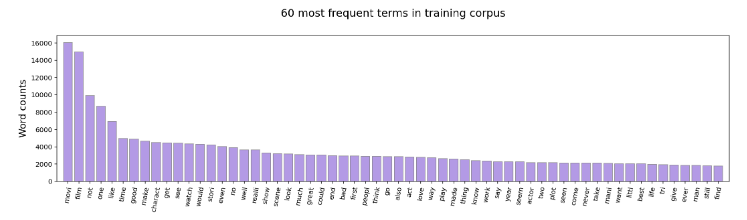

In [22]:
from IPython.display import Image
Image(filename="corpus.png")

As expected, terms such as movi, film, charact, watch, scene, director, etc., appear in the topmost frequent terms in the training data. We can also see terms expressing “sentiment” such as: not, like, good, no, great, love, etc, among the topmost frequent terms. These terms are more likely to be informative about the “sentiment” of a movie review.

In the cells above, we discussed how min_df, max_features, and ngram_range affect term selection in the vocabulary and vocabulary size. Note that all of them are hyper-parameters of the CountVectorizer model, and we can tune them together with a machine learning model to optimize model performance. We will see how to do this at the end of this unit.

### Feature selection
In the unit on AB Testing, we used chi-square tests to test for independence between two categorical variables. Below, we will use the chi-square statistic to find which terms from the vocabulary are mostly related with the sentiment of a movie review (“positive” or “negative”).

Below, we create X, y arrays from the training data.

In [23]:
# Create X, y arrays from training data

# Features
X_train = df["clean_text"].values

# Target values
y_train = df["label"].values

We continue by building a vocabulary using all unigrams and bigrams in the training data while excluding rare terms appearing in less than two documents.



In [24]:
# Create an instance of CountVectorizer
vectorizer = CountVectorizer(
    min_df=2,  # ignore words that appear in less than 2 reviews
    ngram_range=(1, 2),  # consider unigrams and bigrams in the vocabulary
)

# Apply BoW to corpus
X_bow = vectorizer.fit_transform(X_train)
print("Bag of words vectors (before feature selection):      {}\n".format(X_bow.shape))

# Extract vocabulary
vocab = vectorizer.get_feature_names_out()


Bag of words vectors (before feature selection):      (7985, 121519)




Including all unigrams and bigrams in the training data and excluding rare terms resulted in a vocabulary of size 121’519.

Next, we select the top 15’000 terms in the vocabulary, according to the chi-square test, i.e., the most related terms with the sentiment of the movie reviews. We will use the feature_selection.SelectKBest and the feature_selection.chi2 methods from scikit-learn to select vocabulary terms with the highest value for the chi-squared statistic.

In [25]:
# Feature selection according to chi-squared statistics

# Import necessary libraries
from sklearn.feature_selection import SelectKBest, chi2

# Create an instance of the model
ch2 = SelectKBest(chi2, k=15000)

# Apply fit_transform method to training data
X_bow_chi2 = ch2.fit_transform(X_bow, y_train)

print("Bag of words vectors after feature selection: {}".format(X_bow_chi2.shape))

Bag of words vectors after feature selection: (7985, 15000)


Below we plot the top terms according to the chi-square statistic.

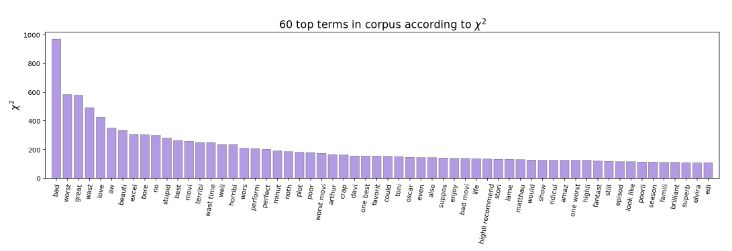

In [26]:
from IPython.display import Image
Image(filename="chi.png")

We can see that the chi-square test favors terms expressing sentiment, such as: bad, worst, great, waste, love, waste time, highly recommend, etc. These words are highly connected with the label of movie reviews (“positive” or “negative”) and we expect them to be useful features for predicting the sentiment of a movie review.

### Feature extraction for text: Tf-idf term weighting
There are also slightly more sophisticated methods that Bag of words that can be used to extract features from text data. Tf-idf term weighting is one of them and works by normalizing word counts by how common a word is in the corpus. We have already discussed the Tf-idf term weighting in the Text Analytics unit from the second Course. The main idea behind Tf-idf is that words that are very frequent across all of documents in the corpus aren’t necessarily “informative” to solve a task and they could shadow rarer yet more interesting terms.

In short, tf-idf term weighting favors terms that are frequent in few documents, and can be implemented with the TfidfVectorizer object from scikit-learn.

Below we import the TfidfVectorizer object from scikit-learn and create an instance of it.

In [27]:
# Weighting text data with Tf-Idf

# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of TfidfVectorizer
tfidf = TfidfVectorizer()

As usual, we call the fit_transform method of TfidfVectorizer on the training corpus.



In [28]:
# X_tfidf: the tf-idf representation of the data
X_tfidf = tfidf.fit_transform(X_train)

print("Shape:      {}\n".format(X_tfidf.shape))

Shape:      (7985, 31888)



## Machine Learning
So far, we have seen how to extract features from text data using the Bag of words and the tf-idf term weighting models. Both models create representations of text data that are sparse and high-dimensional. We also discussed ways to reduce feature space by reducing vocabulary size and performing feature selecting according to the chi-square statistic.

Next we will train a sentiment classifier using a logistic regression model to automatically label movie reviews as positive or negative.

In [29]:
# Create X, y arrays

# Training data
X_train = df["clean_text"].values
y_train = df["label"].values

# Test data
X_test = df_test["clean_text"].values
y_test = df_test["label"].values

print("Training data:", X_train.shape, y_train.shape)
print("Test data:", X_test.shape, y_test.shape)

Training data: (7985,) (7985,)
Test data: (7962,) (7962,)


In [30]:
# Import necessary modules

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [31]:
# Create pipeline
pipe = Pipeline(
    [
        ("vect", None),
        ("feature_selection", SelectKBest(score_func=chi2, k=15000)),
        ("clf", LogisticRegression(solver="liblinear")),
    ]
)

In [33]:
# Prepare the grid search cross validator
grid_cv = GridSearchCV(
    pipe,
    param_grid={
        "vect": [TfidfVectorizer(min_df=2), CountVectorizer(min_df=2)],
        "vect__ngram_range": [(1, 1), (1, 2)],
        "clf__C": np.logspace(-4, 4, 6),
    },
    cv=5,
    return_train_score=True,
    scoring="accuracy",  # Use the accuracy as metric
    verbose=1,
    n_jobs=-1
)

Please note that we are using a small grid to reduce the amount of computation time required to fit the GridSearchCV object below. However, in practice, we would use cv=5 or 10, which are the recommended values when performing k-fold cross-validation.

In [34]:
# Fit estimator
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', None),
                                       ('feature_selection',
                                        SelectKBest(k=15000,
                                                    score_func=<function chi2 at 0x00000255C68EA3A0>)),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.00000000e-04, 3.98107171e-03, 1.58489319e-01, 6.30957344e+00,
       2.51188643e+02, 1.00000000e+04]),
                         'vect': [TfidfVectorizer(min_df=2, ngram_range=(1, 2)),
                                  CountVectorizer(min_df=2)],
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [35]:
# Show best estimator
grid_cv.best_estimator_


Pipeline(steps=[('vect', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('feature_selection',
                 SelectKBest(k=15000,
                             score_func=<function chi2 at 0x00000255C68EA3A0>)),
                ('clf',
                 LogisticRegression(C=251.18864315095823, solver='liblinear'))])

In [36]:
# Collect most interesting results in a DataFrame
cv_results = pd.DataFrame(
    {
        "vectorizer": [type(clf).__name__ for clf in grid_cv.cv_results_["param_vect"]],
        "n_gram": [k for k in grid_cv.cv_results_["param_vect__ngram_range"]],
        "C": [C for C in grid_cv.cv_results_["param_clf__C"]],
        "mean_train_accuracy": grid_cv.cv_results_["mean_train_score"],
        "std_train_accuracy": grid_cv.cv_results_["std_train_score"],
        "mean_validation_accuracy": grid_cv.cv_results_["mean_test_score"],
        "std_validation_accuracy": grid_cv.cv_results_["std_test_score"],
        "mean_fit_time": grid_cv.cv_results_["mean_fit_time"],
    }
)

# Print grid-search results
cv_results.sort_values("mean_validation_accuracy", ascending=False).head(10)


,vectorizer,n_gram,C,mean_train_accuracy,std_train_accuracy,mean_validation_accuracy,std_validation_accuracy,mean_fit_time
17,TfidfVectorizer,"(1, 2)",251.188643,1.000000,0.000000,0.916343,0.005788,7.017484
21,TfidfVectorizer,"(1, 2)",10000.000000,1.000000,0.000000,0.913212,0.004202,6.595088
13,TfidfVectorizer,"(1, 2)",6.309573,0.979618,0.000819,0.907201,0.010971,5.981466
12,TfidfVectorizer,"(1, 1)",6.309573,0.991609,0.000529,0.902943,0.008558,2.334273
16,TfidfVectorizer,"(1, 1)",251.188643,1.000000,0.000000,0.901941,0.006563,2.823771
20,TfidfVectorizer,"(1, 1)",10000.000000,1.000000,0.000000,0.897934,0.005643,2.883423
11,CountVectorizer,"(1, 2)",0.158489,0.988885,0.000754,0.897307,0.007930,7.111293
15,CountVectorizer,"(1, 2)",6.309573,1.000000,0.000000,0.895805,0.008015,8.499392
19,CountVectorizer,"(1, 2)",251.188643,1.000000,0.000000,0.888791,0.006053,8.208778
10,CountVectorizer,"(1, 1)",0.158489,0.991077,0.000760,0.885160,0.007179,2.922469


We can see that the Tf-idf model performs better than the Bag of words model with the dataset. Moreover, including unigrams and bi-grams into our vocabulary was beneficial.

In [38]:
# Compute accuracy on test data
print("Accuracy on test data: {0:.2f}%".format(100 * grid_cv.score(X_test, y_test)))

Accuracy on test data: 85.09%


Our classifier achieved an 85% accuracy on the test data. Let’s use the classification_report to understand better the model’s capability to detect individual classes.

In [39]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_test, grid_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      3987
           1       0.88      0.82      0.85      3975

    accuracy                           0.85      7962
   macro avg       0.85      0.85      0.85      7962
weighted avg       0.85      0.85      0.85      7962



Our model has similar f1-scores for both classes. The differences between the two classes are minor; our model classifies correctly slightly less positive than negative reviews. However, our model makes slightly fewer mistakes when predicting positive reviews.

Let’s take a closer look at these misclassifications with a confusion matrix.

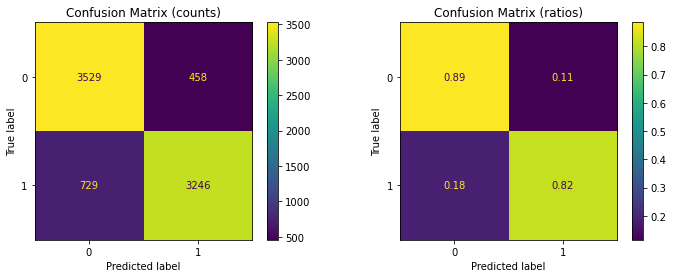

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create two subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plots the standard confusion matrix
ax1.set_title("Confusion Matrix (counts)")
ConfusionMatrixDisplay.from_predictions(
    y_test, grid_cv.predict(X_test), display_labels=[0,1], ax=ax1)

# Plots the normalized confusion matrix
ax2.set_title("Confusion Matrix (ratios)")
ConfusionMatrixDisplay.from_predictions(
    y_test, grid_cv.predict(X_test), normalize="true", display_labels=[0,1], ax=ax2)

plt.show()